# Gold London Liquidity Sweep — Backtest Notebook

**Purpose:** Clean, runnable Jupyter notebook implementing the Gold London Liquidity Sweep strategy (M5). Use this notebook to run backtests on your exported XAUUSD M5 CSV or run a synthetic demo.

**How to use:**
1. Upload your `xau_5m.csv` (columns: Datetime, Open, High, Low, Close, Volume) into the same folder as this notebook.
2. If you don't have data, the notebook can generate synthetic M5-like data for demonstration.
3. Run the cells sequentially. The notebook prints summary stats, shows the equity curve, and saves `xau_london_trades.csv`.

**Output files created:** `xau_london_trades.csv` (trade list)

---

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time
import os

print('Notebook ready - run cells sequentially')

Notebook ready - run cells sequentially


In [8]:
# ===========================
# 1) CLEAN CSV LOADER FOR XAUUSD 5m (IST → UTC)
# ===========================



DATA_FILENAME = 'xau_5m.csv'   # your CSV file

# --- Ensure CSV exists ---
if not os.path.exists(DATA_FILENAME):
    raise FileNotFoundError(f"{DATA_FILENAME} not found. Please place your CSV in the project folder.")

# --- Load CSV ---
df = pd.read_csv(DATA_FILENAME)

# --- Normalize column names ---
df.columns = [c.strip() for c in df.columns]

# --- Validate required columns ---
required = ['Local time', 'Open', 'High', 'Low', 'Close']
for r in required:
    if r not in df.columns:
        raise ValueError(f"Missing column in CSV: {r}")

# --- Step 1: Clean timezone text (remove GMT+0530) ---
df['Local time'] = df['Local time'].str.replace(" GMT+0530", "", regex=False)

# --- Step 2: Parse datetime (format: DD.MM.YYYY HH:MM:SS.mmm) ---
df['Local time'] = pd.to_datetime(
    df['Local time'],
    format="%d.%m.%Y %H:%M:%S.%f"
)

# --- Step 3: Convert IST → UTC ---
df['Local time'] = df['Local time'].dt.tz_localize("Asia/Kolkata").dt.tz_convert("UTC")

# --- Step 4: Set index ---
df = df.set_index('Local time')
df = df.sort_index()

# --- Step 5: Ensure OHLC numeric ---
for col in ['Open', 'High', 'Low', 'Close']:
    df[col] = pd.to_numeric(df[col], errors='raise')

# ---------------------------
# Done — Data is ready.
# ---------------------------
print("CSV loaded successfully.")
print("Rows:", len(df))
print(df.head())


CSV loaded successfully.
Rows: 107424
                               Open      High       Low     Close    Volume
Local time                                                                 
2024-10-31 18:30:00+00:00  2741.105  2745.995  2740.774  2745.815  524190.0
2024-10-31 18:35:00+00:00  2745.795  2747.765  2745.198  2746.445  290910.0
2024-10-31 18:40:00+00:00  2746.498  2746.995  2744.025  2744.705  183310.0
2024-10-31 18:45:00+00:00  2744.655  2746.175  2743.958  2746.145  118200.0
2024-10-31 18:50:00+00:00  2746.145  2746.755  2744.885  2746.175  150060.0


In [9]:
# 2) Strategy parameters (UTC times)


# --- Converted from IST → UTC ---
ASIA_START = time(0,0)
ASIA_END = time(5,30)

PRELONDON_START = time(5,0)
PRELONDON_END = time(7,0)

LONDON_START = time(7,0)
LONDON_ENTRY_END = time(8,0)

# Strategy values
N_BOS = 3
SWING_LOOKBACK = 3
RR = 1
RISK_PER_TRADE = 1

print("Parameters set for UTC")


Parameters set for UTC


In [10]:
# 3) Core functions: session masks, detect sweep, find BOS, simulate

def session_mask(index, start_time, end_time):
    return np.array([(t >= start_time and t <= end_time) for t in index.time])

def detect_asia_range(df_day):
    mask = session_mask(df_day.index, ASIA_START, ASIA_END)
    asia = df_day.iloc[mask]
    if len(asia)==0: return None, None
    return asia['High'].max(), asia['Low'].min()

def detect_sweep(df_day, asia_high, asia_low):
    mask = session_mask(df_day.index, PRELONDON_START, PRELONDON_END)
    pre = df_day.iloc[mask]
    if len(pre)==0: return None
    swept_up = (pre['High'] > asia_high).any()
    swept_down = (pre['Low'] < asia_low).any()
    if swept_up and not swept_down: return 'up'
    if swept_down and not swept_up: return 'down'
    return None

def find_bos_and_enter(df_day, direction):
    mask = session_mask(df_day.index, LONDON_START, LONDON_ENTRY_END)
    london = df_day.iloc[mask]
    if len(london) < N_BOS+1: return None
    for i in range(N_BOS, len(london)-1):
        window = london.iloc[i-N_BOS:i]
        current = london.iloc[i]
        if direction == 'down':
            if current['High'] > window['High'].max():
                entry_time = london.index[i+1]; entry_price = london.iloc[i+1]['Open']
                prev_swing_low = london.iloc[max(0, i-SWING_LOOKBACK):i]['Low'].min()
                if np.isnan(prev_swing_low): continue
                sl = prev_swing_low; tp = entry_price + RR*(entry_price-sl)
                return {'side':'buy','entry_time':entry_time,'entry_price':entry_price,'sl':sl,'tp':tp,'trigger_time':london.index[i]}
        if direction == 'up':
            if current['Low'] < window['Low'].min():
                entry_time = london.index[i+1]; entry_price = london.iloc[i+1]['Open']
                prev_swing_high = london.iloc[max(0, i-SWING_LOOKBACK):i]['High'].max()
                if np.isnan(prev_swing_high): continue
                sl = prev_swing_high; tp = entry_price - RR*(sl-entry_price)
                return {'side':'sell','entry_time':entry_time,'entry_price':entry_price,'sl':sl,'tp':tp,'trigger_time':london.index[i]}
    return None

def simulate_trade_on_day(df_day, trade):
    start_idx = df_day.index.get_loc(trade['entry_time'])
    search = df_day.iloc[start_idx:]
    entry = trade['entry_price']; sl = trade['sl']; tp = trade['tp']; side = trade['side']
    for _, row in search.iterrows():
        high = row['High']; low = row['Low']
        if side == 'buy':
            if low <= sl: return -RISK_PER_TRADE, row.name, sl
            if high >= tp: return RISK_PER_TRADE*RR, row.name, tp
        else:
            if high >= sl: return -RISK_PER_TRADE, row.name, sl
            if low <= tp: return RISK_PER_TRADE*RR, row.name, tp
    last_price = search.iloc[-1]['Close']
    if side == 'buy': pnl = last_price - entry; risk = entry - sl
    else: pnl = entry - last_price; risk = sl - entry
    if risk == 0: return 0, search.index[-1], last_price
    return (pnl/risk)*RISK_PER_TRADE, search.index[-1], last_price

print('Core functions defined')

Core functions defined


In [11]:
## 4) Run backtest on the loaded dataframe
trades = []

for d in sorted(list(set(df.index.date))):
    df_day = df[df.index.date == d]

    # Detect Asia range
    asia_high, asia_low = detect_asia_range(df_day)
    if asia_high is None:
        continue

    # Detect sweep
    sweep = detect_sweep(df_day, asia_high, asia_low)
    if sweep is None:
        continue

    # Detect BOS + entry
    trade = find_bos_and_enter(df_day, sweep)
    if trade is None:
        continue

    # Simulate trade
    r_result, exit_time, exit_price = simulate_trade_on_day(df_day, trade)
    trade['r_result'] = r_result
    trade['exit_time'] = exit_time
    trade['exit_price'] = exit_price
    trades.append(trade)

trades_df = pd.DataFrame(trades)

if trades_df.empty:
    print('No trades detected — try different parameters or data range')

else:
    trades_df = trades_df.sort_values('entry_time').reset_index(drop=True)

    # ============================================================
    #            DYNAMIC RISK MODEL (Your Custom Logic)
    #
    # Normal risk: $50
    # After 2 consecutive loss → next trade = $100
    # After 2 consecutive win → next trade = $25
    # Then return to $50 normally
    # ============================================================

    START_BALANCE = 5000

    NORMAL_RISK = 50
    HIGH_RISK   = 125   # after 2 SL
    LOW_RISK    = 20    # after 2 TP

    risk_list = []
    loss_streak = 0
    win_streak = 0

    # Assign dynamic risk before each trade
    for r in trades_df['r_result']:

        # Determine risk
        if loss_streak >= 2:
            risk = HIGH_RISK      # $100
            loss_streak = 0
            win_streak = 0

        elif win_streak >= 2:
            risk = LOW_RISK       # $25
            win_streak = 0
            loss_streak = 0

        else:
            risk = NORMAL_RISK    # $50

        risk_list.append(risk)

        # Update streaks based on result
        if r < 0:
            loss_streak += 1
            win_streak = 0
        elif r > 0:
            win_streak += 1
            loss_streak = 0
        else:
            win_streak = 0
            loss_streak = 0

    # Save risk per trade
    trades_df['risk_used'] = risk_list

    # Compute equity curve
    equity = START_BALANCE
    equity_curve = []

    for r, risk in zip(trades_df['r_result'], trades_df['risk_used']):
        equity += r * risk
        equity_curve.append(equity)

    trades_df['equity'] = equity_curve
    trades_df['cum_R'] = trades_df['r_result'].cumsum()

    # Summary
    total_trades = len(trades_df)
    win_rate = (trades_df['r_result'] > 0).mean()
    total_R = trades_df['r_result'].sum()
    expectancy = trades_df['r_result'].mean()
    max_dd = (trades_df['equity'].cummax() - trades_df['equity']).max()

    print("Summary:")
    print(f"Total trades: {total_trades}")
    print(f"Win rate: {win_rate:.2%}")
    print(f"Total R: {total_R:.2f}")
    print(f"Expectancy (R): {expectancy:.3f}")
    print(f"Max drawdown ($): {max_dd:.2f}")

    display(trades_df.head(40))
    trades_df.to_csv('xau_london_trades.csv', index=False)
    print("Saved xau_london_trades.csv")


Summary:
Total trades: 136
Win rate: 51.47%
Total R: 4.00
Expectancy (R): 0.029
Max drawdown ($): 450.00


,side,entry_time,entry_price,sl,tp,trigger_time,r_result,exit_time,exit_price,risk_used,equity,cum_R
0,sell,2024-11-01 07:30:00+00:00,2749.985,2751.825,2748.145,2024-11-01 07:25:00+00:00,1,2024-11-01 07:35:00+00:00,2748.145,50,5050,1
1,sell,2024-11-05 07:30:00+00:00,2740.695,2741.235,2740.155,2024-11-05 07:25:00+00:00,1,2024-11-05 07:30:00+00:00,2740.155,50,5100,2
2,buy,2024-11-06 07:20:00+00:00,2730.845,2703.975,2757.715,2024-11-06 07:15:00+00:00,-1,2024-11-06 11:45:00+00:00,2703.975,20,5080,1
3,buy,2024-11-08 07:45:00+00:00,2686.305,2680.215,2692.395,2024-11-08 07:40:00+00:00,1,2024-11-08 11:35:00+00:00,2692.395,50,5130,2
4,buy,2024-11-12 07:55:00+00:00,2602.685,2595.074,2610.296,2024-11-12 07:50:00+00:00,-1,2024-11-12 09:05:00+00:00,2595.074,50,5080,1
5,buy,2024-11-14 07:35:00+00:00,2557.205,2550.425,2563.985,2024-11-14 07:30:00+00:00,-1,2024-11-14 09:30:00+00:00,2550.425,50,5030,0
6,buy,2024-11-15 07:20:00+00:00,2563.295,2559.235,2567.355,2024-11-15 07:15:00+00:00,1,2024-11-15 08:40:00+00:00,2567.355,125,5155,1
7,sell,2024-11-19 07:20:00+00:00,2619.315,2625.165,2613.465,2024-11-19 07:15:00+00:00,-1,2024-11-19 08:40:00+00:00,2625.165,50,5105,0
8,buy,2024-11-20 07:20:00+00:00,2629.118,2627.335,2630.901,2024-11-20 07:15:00+00:00,-1,2024-11-20 07:25:00+00:00,2627.335,50,5055,-1
9,sell,2024-11-21 07:20:00+00:00,2660.685,2661.815,2659.555,2024-11-21 07:15:00+00:00,-1,2024-11-21 07:20:00+00:00,2661.815,125,4930,-2


Saved xau_london_trades.csv


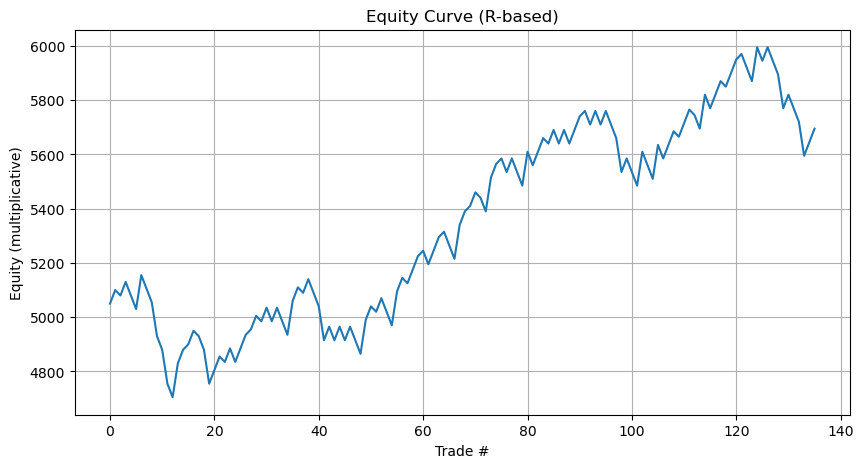

In [12]:
# 5) Equity curve plot
import matplotlib.pyplot as plt
if 'trades_df' in globals() and not trades_df.empty:
    plt.figure(figsize=(10,5))
    plt.plot(trades_df['equity'].values)
    plt.title('Equity Curve (R-based)')
    plt.xlabel('Trade #')
    plt.ylabel('Equity (multiplicative)')
    plt.grid(True)
    plt.show()
else:
    print('No trades to plot')

## Notes & next steps

- Replace synthetic data with real `xau_5m.csv` exported from MT5 for meaningful results.
- Consider adding spread/slippage model and converting R to lot-size for live trading.

Files created by this notebook:
- `xau_london_trades.csv` — trade list

---

Good luck — run the notebook and tell me the results; I can then help analyze parameter sensitivity or convert to live MT5 bot.